In [641]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sc
import networkx as ntx
from numpy.random import choice
import scipy.sparse.linalg as spla
import pandas as pd

In [29]:
def E0(layers):
    m1=[]
    for j in np.arange(0,8*layers,8):
        m1.append([(i+j,i+1+j) for i in range(7)])
    return np.array(m1).reshape(-1,2)
def E1(layers):
    m2=[]
    for j in np.arange(0,8*(layers-1),8):
        m2.append(np.array([((j+i,j+7+i),(j+i,j+7+2+i)) for i in np.arange(1,7,2)]))
    m2=np.array(m2).reshape(-1,2)
    return m2
def E2(layers):
    m3=[]
    m3.append([(j+7,j+14) for j in np.arange(0,8*(layers-1),8)])
    m3=np.array(m3).reshape(-1,2)
    return m3
def E3(layers):
    m4=[]
    m4.append([(8*layers+1,i) for i in np.arange(0,7,2)])
    return np.array(m4).reshape(-1,2)


def E4(layers):
    m5=[]
    m5.append([(layers*8,i) for i in np.arange((layers-1)*8+1,layers*8,2)])
    return np.array(m5).reshape(-1,2)

In [193]:
def create_graph(layers,seed):
    np.random.seed(seed)
    number_of_indices = 8*layers
    G = ntx.Graph()
    #G.add_nodes_from(range(8 * layers))
    e0 = E0(layers)
    e1 = E1(layers)
    e2 = E2(layers)
    e3 = E3(layers)
    e4 = E4(layers)
    G.add_edges_from(e0)
    G.add_edges_from(e1)
    G.add_edges_from(e2)
  #  G.add_edges_from(e3)
  #  G.add_edges_from(e4)
#    G.add_edges_from(((0,11),(6,20)))
    return G

In [207]:
print(list(create_3d_graph(4,1,2).neighbors((0,1))))

[(1, 0), (1, 1)]


In [655]:
def create_3d_graph(layers, seed, depth):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    node_count = 0
    node_mapping = {}  # Map old node to new sequential index

    for z in range(depth):
        for node in G_2d.nodes:
            G_3d.add_node(node_count)
            node_mapping[(node, z)] = node_count
            node_count += 1

    for edge in G_2d.edges:
        for z in range(depth):
            G_3d.add_edge(
                node_mapping[(edge[0], z)], node_mapping[(edge[1], z)]
            )

    # Connect layers vertically (with the correction)
    for z in range(depth - 1):
        for node in G_2d.nodes:
            if node % 2 == 1 and node < max(G_2d.nodes):
                for neighbor in G_2d.neighbors(node):
                    if neighbor % 2 == 0:  # Even neighbors in the current layer
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )
                    elif neighbor % 2 == 1 and neighbor > node: # Odd neighbors in the current layer with a higher index
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )

    node_count = max(G_3d.nodes) + 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 1
    external_node_1 = node_count

    node_count += 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 2
    external_node_2 = node_count

    # Connect bottom layer even nodes to external_node_1
    for node in G_2d.nodes:
        if node % 2 == 0:
            G_3d.add_edge(node_mapping[(node, 0)], external_node_1)  # Bottom layer (z=0)

    # Connect top layer odd nodes to external_node_2
    for node in G_2d.nodes:
        if node % 2 == 1 and node < max(G_2d.nodes):
            G_3d.add_edge(node_mapping[(node, depth - 1)], external_node_2)  # Top layer (z=depth-1)


    return G_3d,external_node_1,external_node_2


In [533]:
create_3d_graph(4, 1, 10)

(<networkx.classes.graph.Graph at 0x7c041234f750>, 320, 321)

In [615]:
print(list(create_3d_graph(4,1,2).neighbors(65)))

[33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]


In [253]:
# Extract node positions for plotting
#pos_3d = {node: (node[0], node[1]) for node in create_3d_graph(4, 1, 2).edges}  
#pos_3d

In [657]:
def generate_random_values(mean, std, seed, num_edges):
    np.random.seed(seed)
    return np.abs(np.random.normal(mean, std, num_edges))

In [659]:

def matrix_interactions(seed, depth, h, std):
    """
    Creates an interaction matrix based on a 3D graph structure.

    Args:
        seed (int): Seed for random number generation.
        depth (int): Likely related to the complexity of the 3D graph.
        h (float): Unused parameter in the provided code.
        std (float): Standard deviation for generating random values.

    Returns:
        adjM (scipy.sparse.lil_matrix): The adjacency matrix representing interactions.
        nodes (int): The number of nodes in the graph.
        xxx (numpy.ndarray): An array representing the edges of the graph.
    """

    grid,a,b = create_3d_graph(4, seed, depth)  # Assuming this function exists
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()

    cap_values = np.abs(1 * generate_random_values(10, std, seed, num_edges))
    interactions = 1 / cap_values

    # Initialize adjacency matrix with correct dimensions
    adjM = sc.lil_matrix((nodes, nodes))

    # Extract edges and ensure valid indices
    xxx = list(grid.edges())
    #print(xxx)

    # Check if all node indices in the edges are valid
#  assert len(interactions) == xxx.shape[0], "Invalid node indices found in edges!"

    # Fill adjacency matrix with interaction values
    for edge_idx, (i, j) in enumerate(xxx):
        if i < a:
            interaction_value = interactions[edge_idx]
            adjM[i, j] = interaction_value
            adjM[j, i] = interaction_value
        else :
            interaction_value = interactions[edge_idx]
            adjM[i, j] = 0.001
            adjM[j, i] = 0.001
            

    # Set diagonal elements based on row sums
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 - 0.0001)

    # Invert the matrix (assuming adjM is negative definite)
    MI = spla.inv(-1 * adjM.tocsc())

    return MI, xxx


In [591]:
n,m = matrix_interactions(4,2,1,0)

In [609]:
#m

In [661]:
def R(seed,a,b,std):
    MI,nodes = matrix_interactions(seed,50,1,std)
    return MI[a, b] + MI[b, b] - MI[a,b] - MI[b, a] 

In [663]:
joop=[np.mean([R(seed,1600,1601,std) for seed in range(3)]) for std in np.arange(0.0,5,0.1)]

Text(0.5, 1.0, '$R_{\\mu} = 10$, # of flakes = 1600,# of in plane = 16')

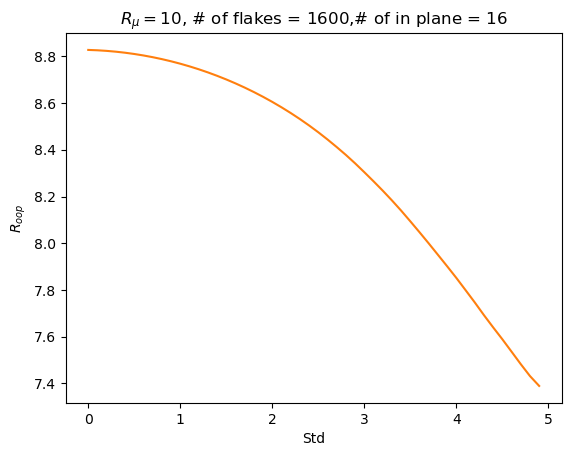

In [589]:
plt.plot(np.arange(0,5,0.1),joop)
plt.xlabel('Std')
plt.ylabel(r'$R_{oop}$')
plt.title(r'$R_{\mu} = 10$, # of flakes = 1600,# of in plane = 16')

In [617]:
# depth decides # no of flakes in the box
def create_3d_graph_ip(layers, seed, depth):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    node_count = 0
    node_mapping = {}  # Map old node to new sequential index

    for z in range(depth):
        for node in G_2d.nodes:
            G_3d.add_node(node_count)
            node_mapping[(node, z)] = node_count
            node_count += 1

    for edge in G_2d.edges:
        for z in range(depth):
            G_3d.add_edge(
                node_mapping[(edge[0], z)], node_mapping[(edge[1], z)]
            )

    # Connect layers vertically (with the correction)
    for z in range(depth - 1):
        for node in G_2d.nodes:
            if node % 2 == 1 and node < max(G_2d.nodes):
                for neighbor in G_2d.neighbors(node):
                    if neighbor % 2 == 0:  # Even neighbors in the current layer
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )
                    elif neighbor % 2 == 1 and neighbor > node: # Odd neighbors in the current layer with a higher index
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )

    node_count = max(G_3d.nodes) + 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 1
    external_node_1 = node_count

    node_count += 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 2
    external_node_2 = node_count

    # Connect side layer even nodes to external_node_1
    for x in range(depth):
        for node in G_2d.nodes:
            if node % 8 == 0:
                G_3d.add_edge(node_mapping[(node, x)], external_node_1)  # side l

    # Connect side layer odd nodes to external_node_2
    for x in range(depth):
        for node in G_2d.nodes:
            if node % 8 == 7 :
                G_3d.add_edge(node_mapping[(node, x)], external_node_2)  # Top layer (z=depth-1)


    return G_3d,external_node_1,external_node_2


In [631]:

def matrix_interactions_ip(seed, depth, h, std):
    """
    Creates an interaction matrix based on a 3D graph structure.

    Args:
        seed (int): Seed for random number generation.
        depth (int): Likely related to the complexity of the 3D graph.
        h (float): Unused parameter in the provided code.
        std (float): Standard deviation for generating random values.

    Returns:
        adjM (scipy.sparse.lil_matrix): The adjacency matrix representing interactions.
        nodes (int): The number of nodes in the graph.
        xxx (numpy.ndarray): An array representing the edges of the graph.
    """

    grid,a,b = create_3d_graph_ip(4, seed, depth)  # Assuming this function exists
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()

    cap_values = np.abs(1 * generate_random_values(10, std, seed, num_edges))
    interactions = 1 / cap_values

    # Initialize adjacency matrix with correct dimensions
    adjM = sc.lil_matrix((nodes, nodes))

    # Extract edges and ensure valid indices
    xxx = list(grid.edges())
    #print(xxx)

    # Check if all node indices in the edges are valid
#  assert len(interactions) == xxx.shape[0], "Invalid node indices found in edges!"

    # Fill adjacency matrix with interaction values
    for edge_idx, (i, j) in enumerate(xxx):
        if i < a:
            interaction_value = interactions[edge_idx]
            adjM[i, j] = interaction_value
            adjM[j, i] = interaction_value
        else :
            interaction_value = interactions[edge_idx]
            adjM[i, j] = 0.001
            adjM[j, i] = 0.001
            

    # Set diagonal elements based on row sums
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 - 0.0001)

    # Invert the matrix (assuming adjM is negative definite)
    MI = spla.inv(-1 * adjM.tocsc())

    return MI, a,b


In [633]:
def R_ip(seed,std):
    MI,a,b = matrix_interactions_ip(seed,50,1,std)
    return MI[a, b] + MI[b, b] - MI[a,b] - MI[b, a] 

In [635]:
jip=[np.mean([R_ip(seed,std) for seed in range(3)]) for std in np.arange(0,5,0.1)]

Text(0.5, 1.0, '$R_{\\mu} = 10$, # of flakes = 1600,# of in plane = 16')

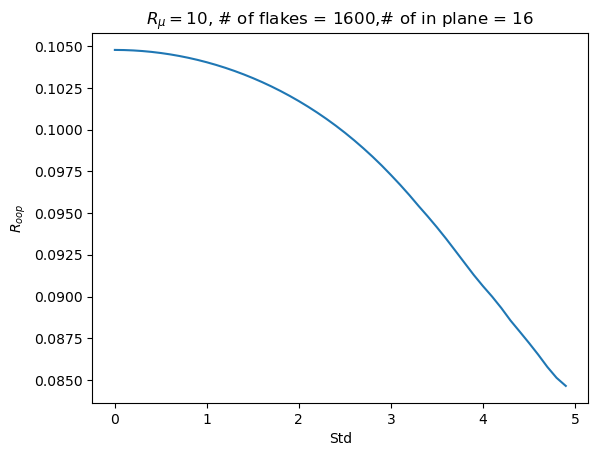

In [636]:
plt.plot(np.arange(0,5,0.1),jip)
plt.xlabel('Std')
plt.ylabel(r'$R_{oop}$')
plt.title(r'$R_{\mu} = 10$, # of flakes = 1600,# of in plane = 16')

In [709]:
df = pd.DataFrame()
df["Rop"] = joop
df["Rip"]= jip

In [711]:
df["ratio"] = df["Rop"]/df["Rip"]

In [707]:
#print(df)

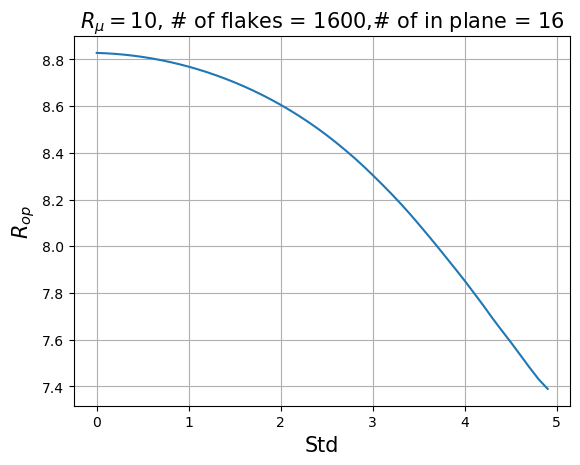

In [727]:
plt.plot(np.arange(0,5,0.1),df["Rop"],label=r'$R_{op}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$R_{op}$',fontsize=15)
plt.title(r'$R_{\mu} = 10$, # of flakes = 1600,# of in plane = 16',fontsize=15)
plt.grid(True)


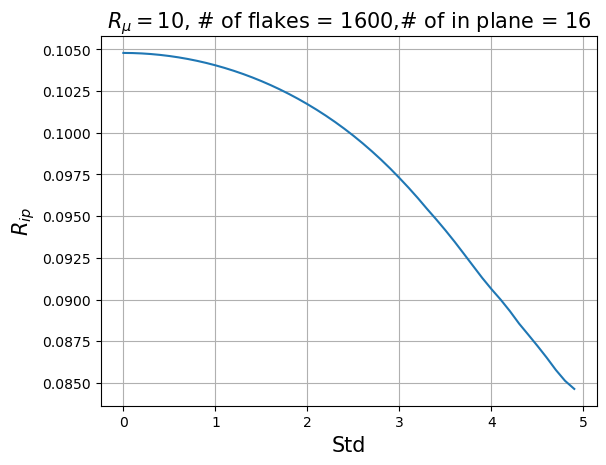

In [735]:
plt.plot(np.arange(0,5,0.1),df["Rip"],label=r'$R_{ip}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$R_{ip}$',fontsize=15)
plt.title(r'$R_{\mu} = 10$, # of flakes = 1600,# of in plane = 16',fontsize=15)
plt.grid(True)


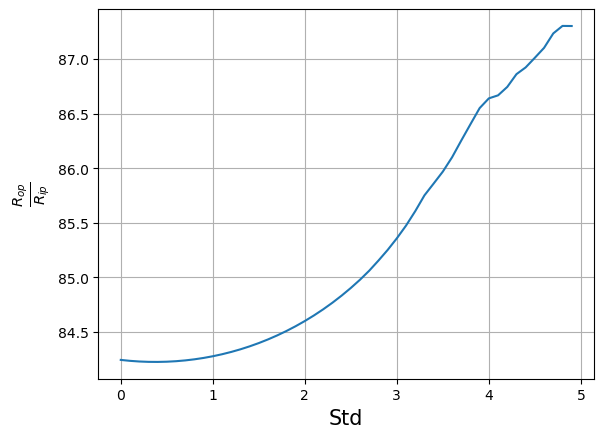

In [733]:
plt.plot(np.arange(0, 5, 0.1), df["ratio"], label=r'$\frac{R_{op}}{R_{ip}}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$\frac{R_{op}}{R_{ip}}$',fontsize=15)
plt.grid(True)
